In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing_environment import PricingEnvironment
from pricing_agent import SWUCBAgent,CUSUMUCBAgent

In [7]:
#different curves
n_cust=100
discretization=20
noise=0.1
curve1=lambda p,noise_factor=noise: np.clip(0.95-0.9*p**5+np.random.uniform(-noise_factor,noise_factor),0,1)
curve2=lambda p,noise_factor=noise: np.clip(np.exp(-4*p)+np.random.uniform(-noise_factor,noise_factor),0,1)
curve3=lambda p,noise_factor=noise: np.clip(1-0.4/(1+np.exp(-20*(p-0.2)))-0.5/(1+np.exp(-30*(p-0.6)))+np.random.uniform(-noise_factor,noise_factor),0,1)
curve4=lambda p,noise_factor=noise: np.clip(1-np.tanh(0.75+p**2)+np.random.uniform(-noise_factor,noise_factor),0,1)
norm_dem_curves=[curve1,curve2,curve3,curve4]

Note that all the probabilities are clipped between 0 and 1

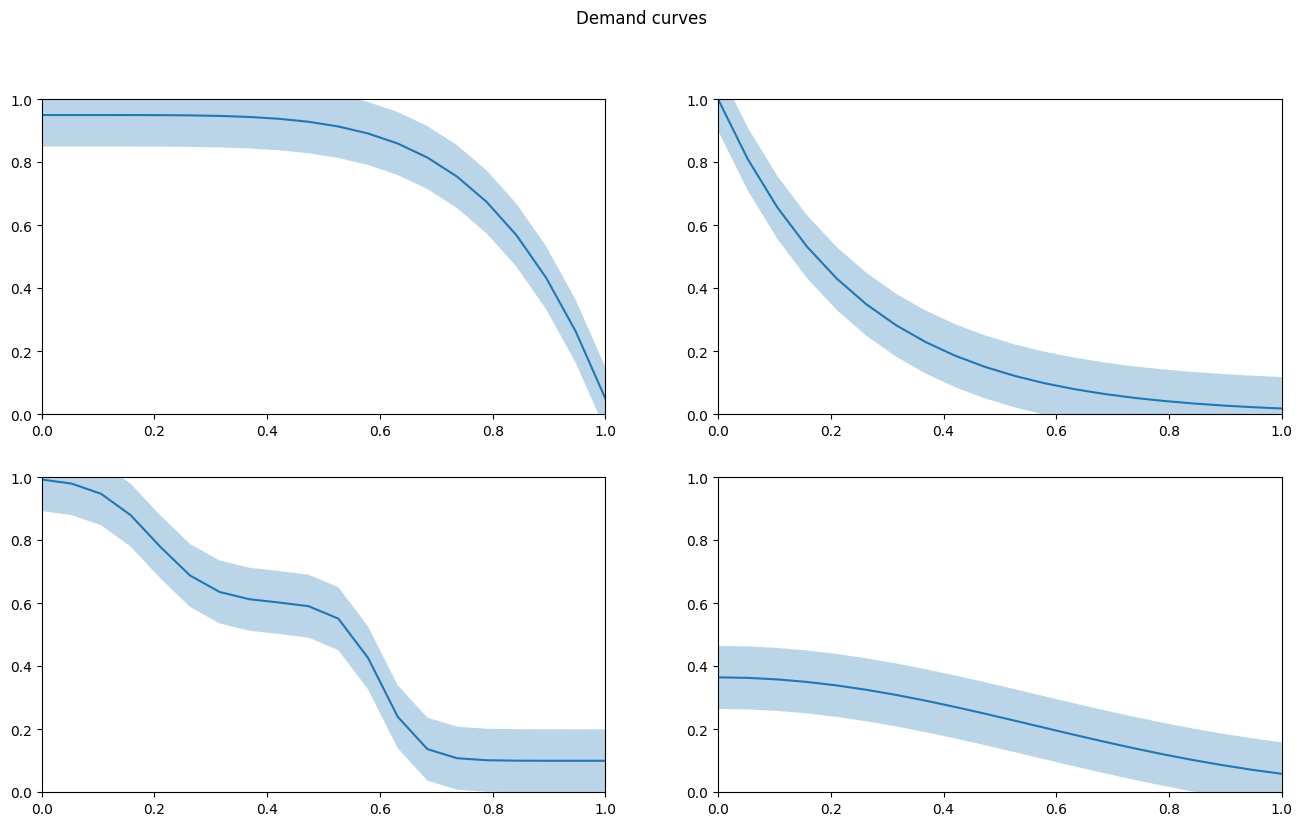

In [8]:
prices=np.linspace(0,1,discretization)
fig,axs=plt.subplots(2,2,figsize=(16,9))
fig.suptitle('Demand curves')
axs=axs.reshape(-1)
for i in range(len(axs)):
    probs=norm_dem_curves[i](prices,noise_factor=0)
    axs[i].plot(prices,probs)
    axs[i].fill_between(prices,probs-noise, probs+noise, alpha=0.3)
    axs[i].set_ylim(ymin=0,ymax=1)
    axs[i].set_xlim(xmin=0,xmax=1)
    #axs[i].legend()


Best_price for demand curve number 0: 0.7368421052631579
Best_price for demand curve number 1: 0.47368421052631576
Best_price for demand curve number 2: 0.5263157894736842
Best_price for demand curve number 3: 0.631578947368421


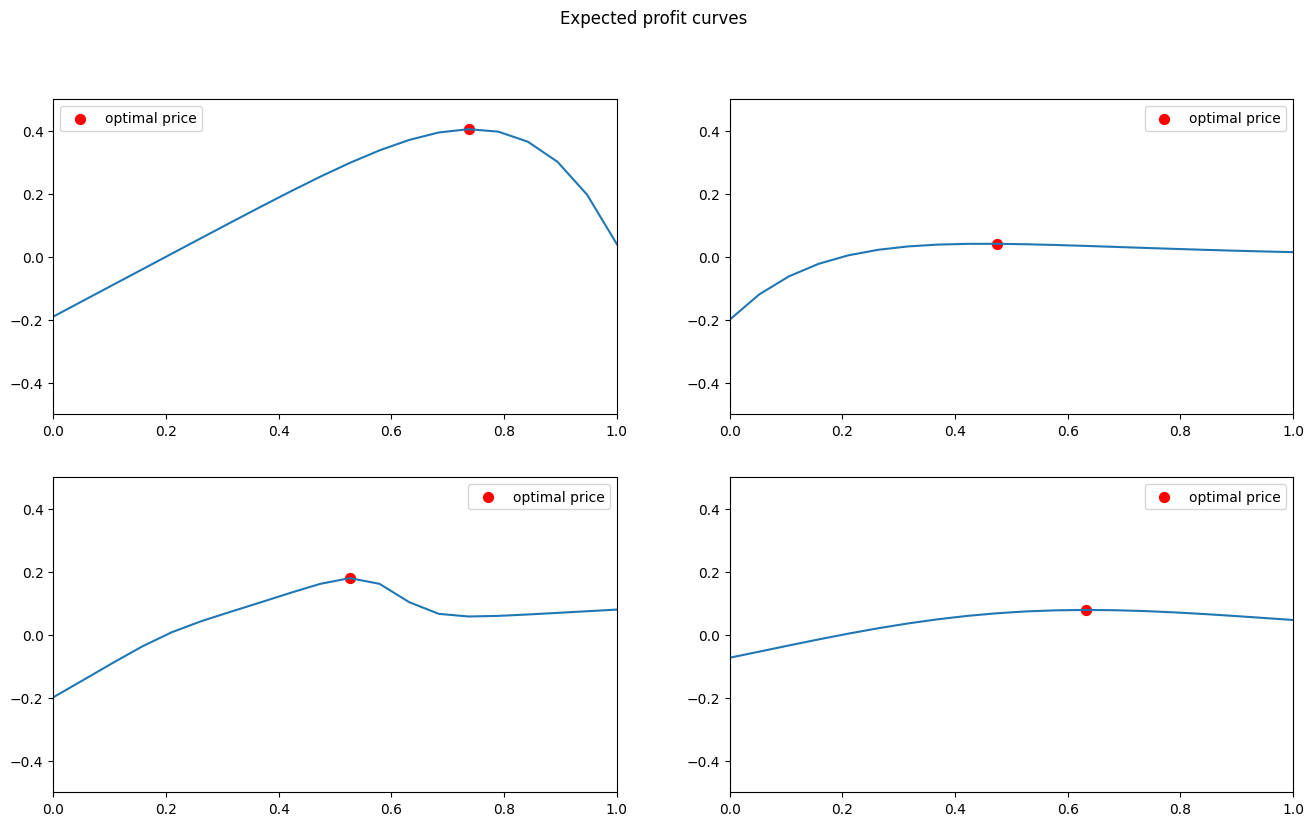

In [9]:
cost=0.2
prices=np.linspace(0,1,discretization)


fig,axs=plt.subplots(2,2,figsize=(16,9))
fig.suptitle('Expected profit curves')
axs=axs.reshape(-1)
best_prices=[0,0,0,0]
for i in range(len(axs)):
    expected_profit_curve = norm_dem_curves[i](prices,noise_factor=0)*(prices-cost)
    best_price_index = np.argmax(expected_profit_curve)
    best_prices[i] = prices[best_price_index]
    axs[i].plot(prices,expected_profit_curve)
    axs[i].set_ylim(ymin=-0.5,ymax=0.5)
    axs[i].set_xlim(xmin=0,xmax=1)
    axs[i].scatter(best_prices[i], expected_profit_curve[best_price_index], color='red', s=50,label='optimal price')
    axs[i].legend()
    print(f'Best_price for demand curve number {i}: {best_prices[i]}')
#fig.suptitle('Demand curves')

In [10]:
#use mean reward using every arm sequentially, in order to scale the explorative incentive
T=80
num_cust=100
prices=np.linspace(0,1,discretization)
indexes=[int(T/4),int(2*T/4),int(3*T/4),T+1]
prices=np.linspace(0,1,discretization)
env=PricingEnvironment(norm_dem_curves,cost,indexes)

i=0
rew=0
for t in range(T):
    price=prices[i]
    i+=1
    d,r=env.round(price,num_cust)
    rew+=r/100
    if i>=len(prices):
        i=0
scale=rew/T
scale

0.06414868421052632

## SWUCB

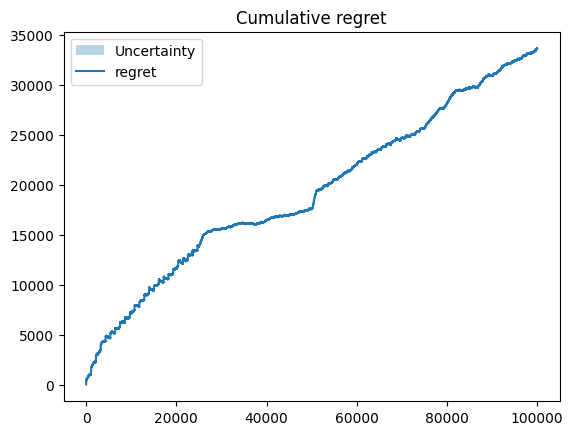

In [15]:
np.seterr('ignore')
T=100000
num_cust=100
prices=np.linspace(0,1,discretization)
indexes=[int(T/4),int(2*T/4),int(3*T/4),T+1]
W = int(2*np.sqrt(T*np.log(T)/4))



regret_per_trial=[]

#get clairvoyant
clair_prices=np.zeros(T)
clair_prices[0:indexes[0]]=best_prices[0]
clair_prices[indexes[0]:indexes[1]]=best_prices[1]
clair_prices[indexes[1]:indexes[2]]=best_prices[2]
clair_prices[indexes[2]:indexes[3]]=best_prices[3]

seeds=[13]

for seed in seeds:
    np.random.seed(seed)
    #decrease scale because of permanent exploration
    agent=SWUCBAgent(discretization,T,W,prices,range=scale/8)
    env=PricingEnvironment(norm_dem_curves,cost,indexes)
    pulls=np.array([])
    rewards=np.array([])
    clair_reward=np.array([])
    for t in range(T):
        p_t = agent.pull_arm()
        d_t, r_t = env.round(p_t, num_cust,debug=False)
        agent.update(r_t/num_cust)
        rewards = np.append(rewards, r_t)
        pulls=np.append(pulls,p_t)
        dc,rc=env.round(clair_prices[t],num_cust,clairvoyant=True)
        clair_reward = np.append(clair_reward, rc)
        
    cumulative_regret=np.cumsum(clair_reward-rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
n_trials=1
plt.fill_between(np.arange(T),average_regret-regret_sd/np.sqrt(n_trials),average_regret+regret_sd/np.sqrt(n_trials),alpha=0.3,label='Uncertainty')

plt.plot(average_regret,label='regret')
plt.title('Cumulative regret')
plt.legend()
plt.show()

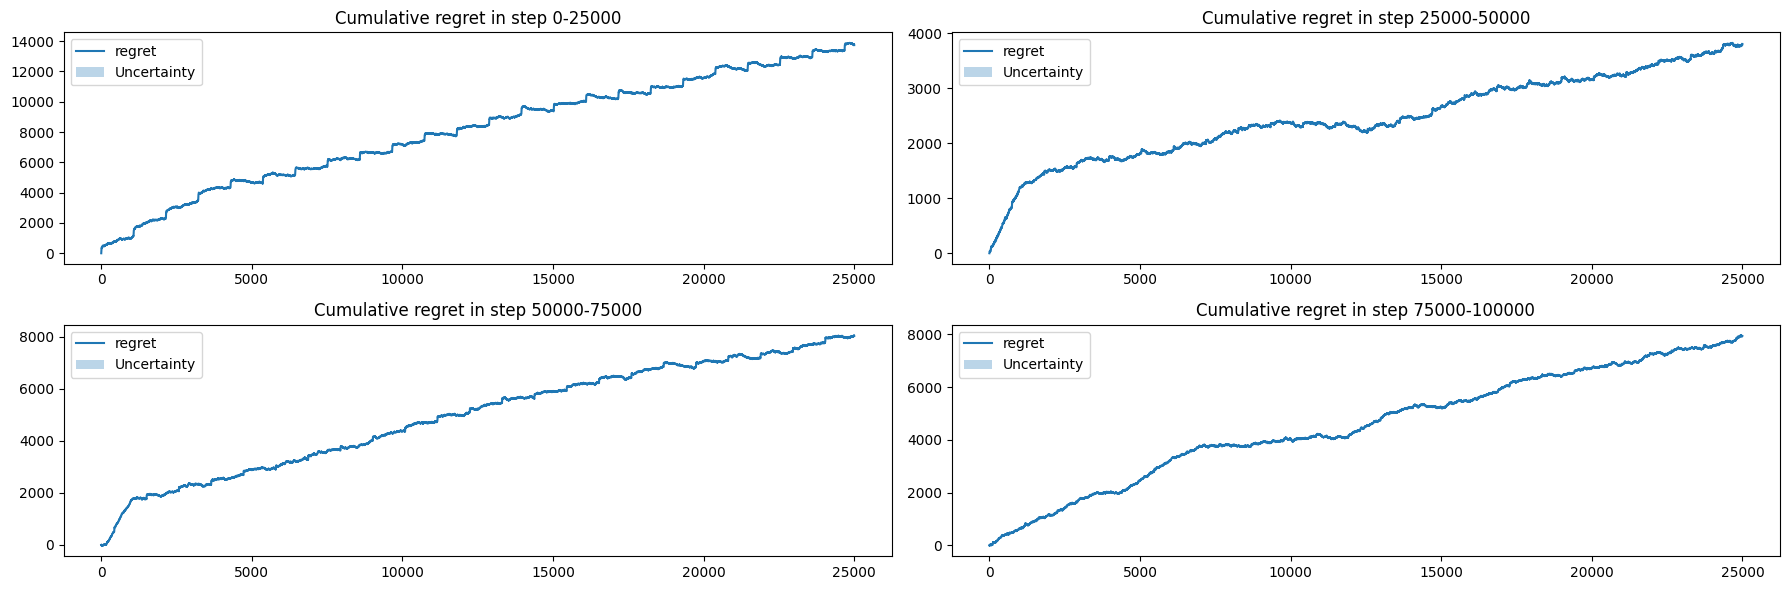

In [16]:
fig,axs=plt.subplots(2,2,figsize=(18,6))
axs=axs.reshape(-1)
idxs=[0,*indexes]
idxs[-1]-=1
for i in range(len(idxs)-1):
    fraction_regret=average_regret[idxs[i]:idxs[i+1]]-average_regret[idxs[i]]
    fraction_std=regret_sd[idxs[i]:idxs[i+1]]
    axs[i].plot(fraction_regret,label='regret')
    axs[i].fill_between(np.arange(idxs[i+1]-idxs[i]),fraction_regret-fraction_std,fraction_regret+fraction_std,alpha=0.3,label='Uncertainty')
    axs[i].set_title(f'Cumulative regret in step {idxs[i]}-{idxs[i+1]}')
    axs[i].legend()
fig.tight_layout()
#fig.show()

In the first interval, the regret is much higher (even after normalising), probably due to the fact that the profit curve varies a lot from the optimal arm to the suboptimal ones. In the other intervals, instead, there is a small area near the optimal arm that is very close to the optimal value. So, after committing to the optimal arm of the previous interval and some exploration (that give higher regret), we get closer to the optimal arm of the current interval and the regret is much smaller, even when we don't choose the optimal arm.

## CUSUM

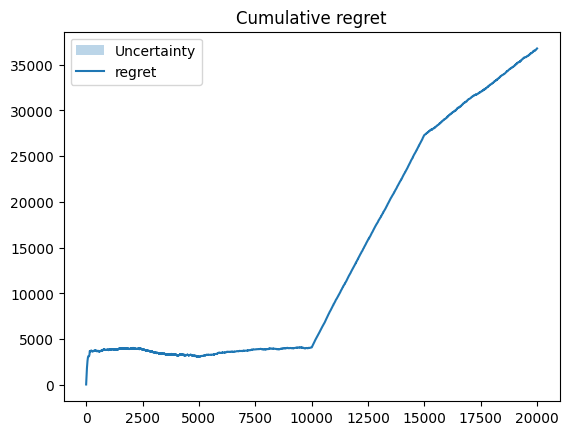

In [13]:
np.seterr('ignore')
T=20000
num_cust=100
prices=np.linspace(0,1,discretization)
indexes=[int(T/4),int(2*T/4),int(3*T/4),T+1]

h = 2*np.log(T/4)
M = int(np.log(T/4))

scale=0.05
regret_per_trial=[]

#get clairvoyant
clair_prices=np.zeros(T)
clair_prices[0:indexes[0]]=best_prices[0]
clair_prices[indexes[0]:indexes[1]]=best_prices[1]
clair_prices[indexes[1]:indexes[2]]=best_prices[2]
clair_prices[indexes[2]:indexes[3]]=best_prices[3]

seeds=[1]

for seed in seeds:
    np.random.seed(seed)
    agent=CUSUMUCBAgent(discretization,T,M,h,prices,range=scale)
    env=PricingEnvironment(norm_dem_curves,cost,indexes)
    pulls=np.array([])
    rewards=np.array([])
    clair_reward=np.array([])
    for t in range(T):
        p_t = agent.pull_arm()
        d_t, r_t = env.round(p_t, num_cust,debug=False)
        agent.update(r_t/num_cust)
        rewards = np.append(rewards, r_t)
        pulls=np.append(pulls,p_t)
        dc,rc=env.round(clair_prices[t],num_cust,clairvoyant=True)
        clair_reward = np.append(clair_reward, rc)
    cumulative_regret=np.cumsum(clair_reward-rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
n_trials=1
plt.fill_between(np.arange(T),average_regret-regret_sd/np.sqrt(n_trials),average_regret+regret_sd/np.sqrt(n_trials),alpha=0.3,label='Uncertainty')

plt.plot(cumulative_regret,label='regret')
plt.title('Cumulative regret')
plt.legend()
plt.show()

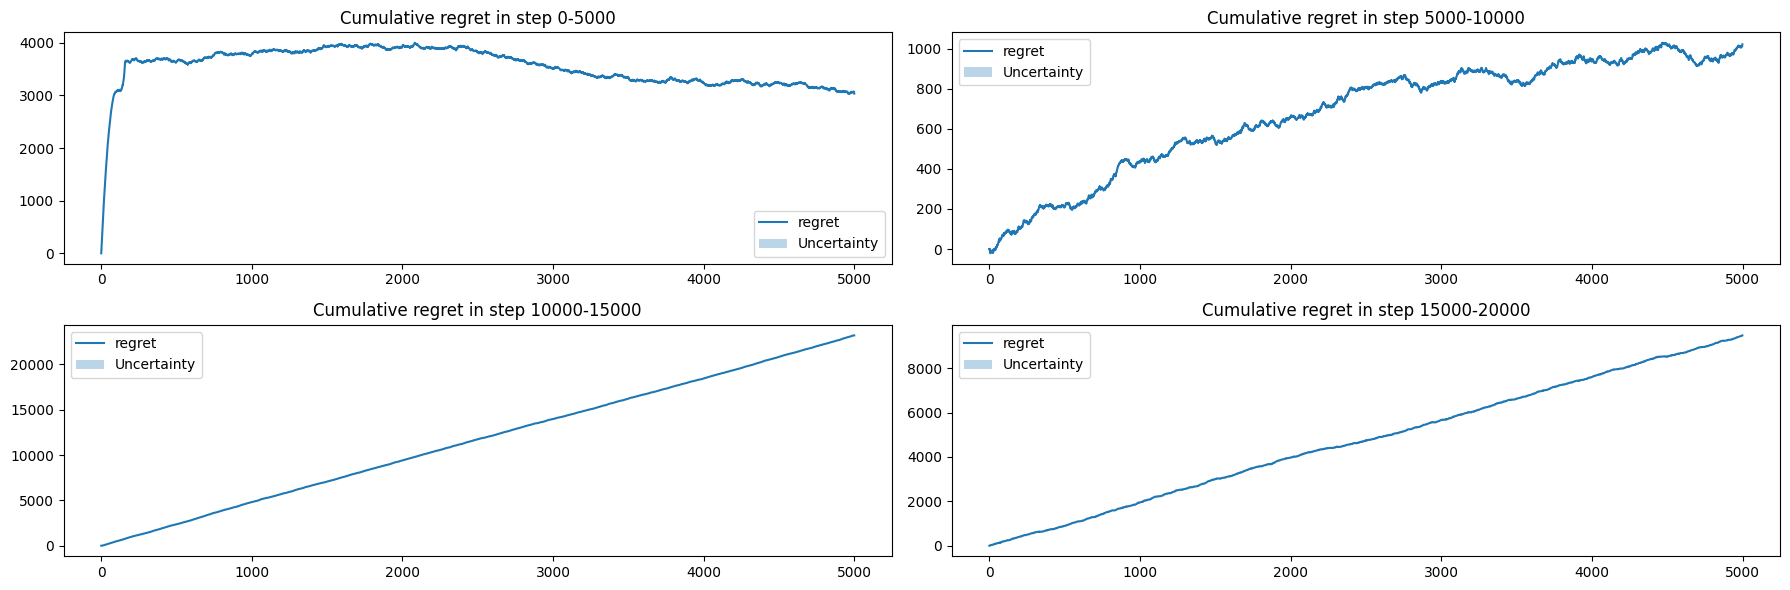

In [14]:
fig,axs=plt.subplots(2,2,figsize=(18,6))
axs=axs.reshape(-1)
idxs=[0,*indexes]
idxs[-1]-=1
for i in range(len(idxs)-1):
    fraction_regret=average_regret[idxs[i]:idxs[i+1]]-average_regret[idxs[i]]
    fraction_std=regret_sd[idxs[i]:idxs[i+1]]
    axs[i].plot(fraction_regret,label='regret')
    axs[i].fill_between(np.arange(idxs[i+1]-idxs[i]),fraction_regret-fraction_std,fraction_regret+fraction_std,alpha=0.3,label='Uncertainty')
    axs[i].set_title(f'Cumulative regret in step {idxs[i]}-{idxs[i+1]}')
    axs[i].legend()
fig.tight_layout()
#fig.show()

## EXPLANATION:
CUSUM failed to detect a change in the last 2 intervals. It is possible to lower the change detector threshold to solve this. In this aspect, the environment is a bit tricky, because while the optimal arm changes, the expected reward of the previous optimal arm does not change much (as we can see from the previous profit curves). So, our agent keeps playing the suboptimal arm exploring too little. 
It is really easy to solve It, either by modifying the demand curves (sweeping it under the rug) or by making the change detector more sensitive and making It explore more. However, we decided to leave It as a demonstration of the limits of the change detector.

In the first interval, the regret decreases in the last part. Because of the binomial distribution and the noise, there is a high variability once we find the optimal arm. We can see this really well trying different seeds. The only costant is the regret in the 3rd and 4th intervals.

## BONUS

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pricing_environment import Two_items_PricingEnvironment
from pricing_agent import GPUCB

In [9]:
n_cust=100

f1=lambda x,y,noise=0.1: np.clip(1-0.2*(3*x**2+y**3)+noise*np.random.normal(0,noise),0,1)
f2=lambda x,y,noise=0.1: np.clip(1-0.5*(0.5*np.cos(x)+2*np.sin(y))+noise*np.random.normal(0,noise),0,1)
f=lambda x,y,c1,c2,noise=0.1: f1(x,y,noise)*(x-c1)+f2(x,y,noise)*(y-c2)

x=np.linspace(0,1,100)
y=np.linspace(0,1,100)
X,Y=np.meshgrid(x,y)

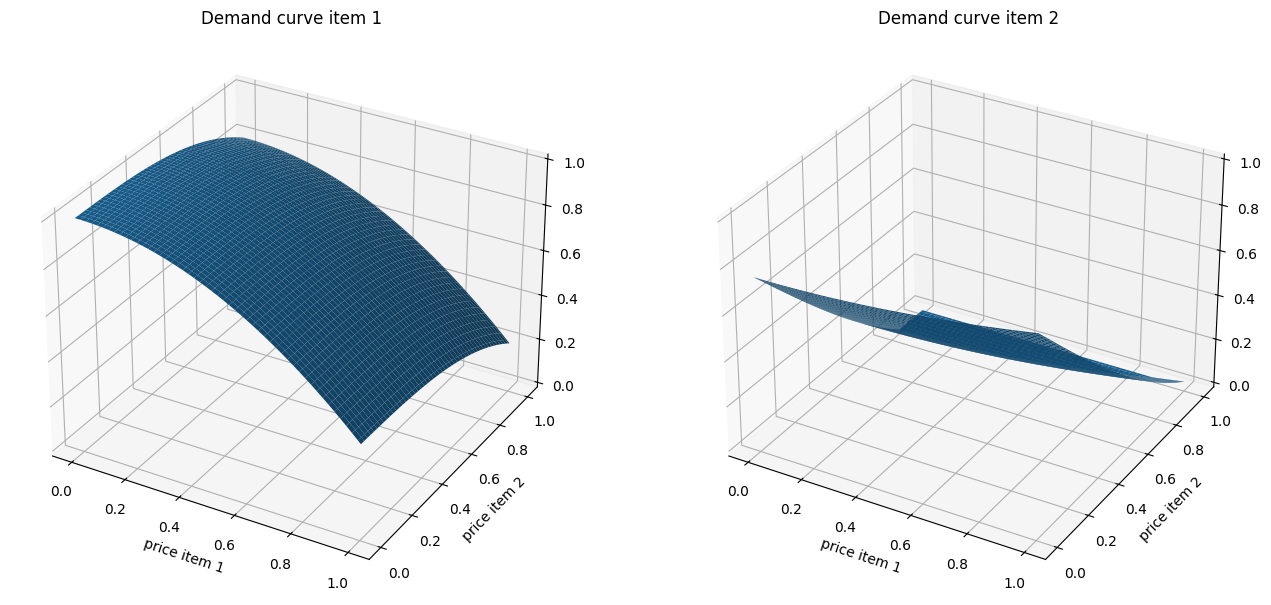

In [10]:
dem1=f1(X,Y,noise=0)
fig=plt.figure(figsize=(16,9))
ax=fig.add_subplot(121,projection='3d')
ax.plot_surface(X,Y,dem1)
ax.set_xlabel('price item 1')
ax.set_ylabel('price item 2')
ax.set_title('Demand curve item 1')
ax.set_zlim(zmin=0,zmax=1)

dem2=f2(X,Y,noise=0)
ax=fig.add_subplot(122,projection='3d')
ax.plot_surface(X,Y,dem2)
ax.set_xlabel('price item 1')
ax.set_ylabel('price item 2')
ax.set_title('Demand curve item 2')
ax.set_zlim(zmin=0,zmax=1)


plt.show()

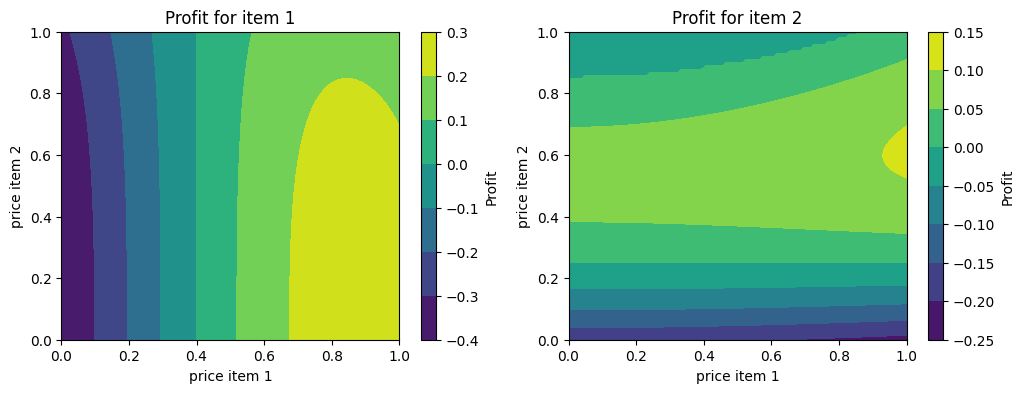

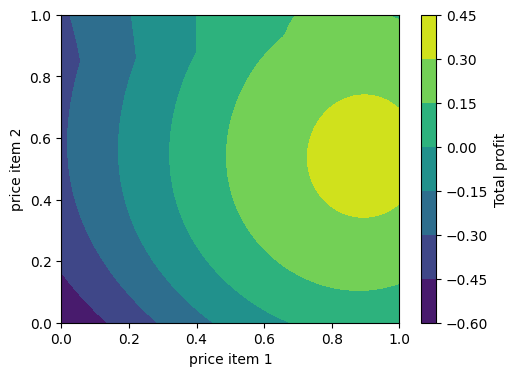

In [11]:
c1=0.4
c2=0.25

fig=plt.figure(figsize=(12,4))

profit_i1=f1(X,Y,noise=0)*(X-c1)
ax=fig.add_subplot(121)
ax.set_title('Profit for item 1')
cp=ax.contourf(X,Y,profit_i1)
plt.colorbar(cp,label='Profit')
plt.xlabel('price item 1')
plt.ylabel('price item 2')

profit_i2=f2(X,Y,noise=0)*(Y-c2)
ax=fig.add_subplot(122)
ax.set_title('Profit for item 2')
cp=ax.contourf(X,Y,profit_i2)
plt.colorbar(cp,label='Profit')
plt.xlabel('price item 1')
plt.ylabel('price item 2')

fig=plt.figure(figsize=(12,4))
tot_profit=f(X,Y,c1,c2,0)
ax=fig.add_subplot(121)
cp=ax.contourf(X,Y,tot_profit)
plt.colorbar(cp,label='Total profit')
plt.xlabel('price item 1')
plt.ylabel('price item 2')
plt.show()

In [18]:
args=np.unravel_index(np.argmax(tot_profit),tot_profit.shape)
best_p1=x[args[1]]
best_p2=x[args[0]]
print(f'Best price p1: {best_p1.round(2)}, best price p2: {best_p2.round(2)}\nBest profit: {f(best_p1,best_p2,c1,c2,0).round(2)}')

Best price p1: 0.9, best price p2: 0.54
Best profit: 0.34


In [43]:
T=200
num_cust=100
rewards=np.array([])
clair_reward=np.array([])

env=Two_items_PricingEnvironment(f1,f2,c1,c2)
agent=GPUCB(T,x,y,scale=2)

for t in range(T):
    p_t = agent.pull_arm()
    n1,n2, r1,r2 = env.round(*p_t, num_cust)
    agent.update((r1+r2)/num_cust)
    rewards = np.append(rewards, (r1+r2))
    n1c,n2c,r1c,r2c=env.round(best_p1,best_p2,num_cust)
    clair_reward = np.append(clair_reward, r1c+r2c)

C:\Users\emanu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\emanu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\emanu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarn

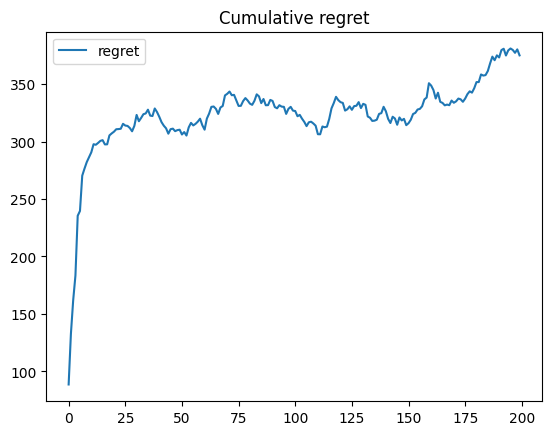

In [44]:
cum_clair_reward=np.cumsum(clair_reward)
cum_reward=np.cumsum(rewards)
plt.plot(cum_clair_reward-cum_reward,label='regret')
plt.title('Cumulative regret')
plt.legend()

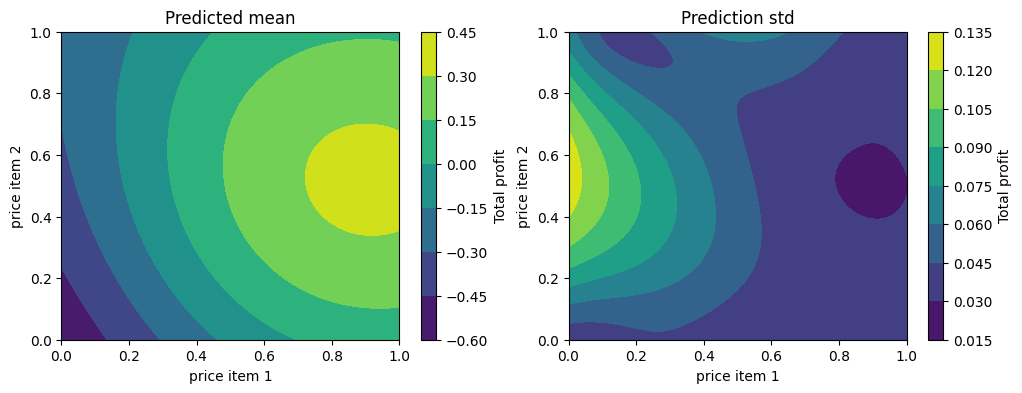

In [45]:
preds=agent.get_predictions()
#predicted_profit=agent.get_predictions()
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(121)
ax.set_title('Predicted mean')
cp=ax.contourf(X,Y,preds[0])
plt.colorbar(cp,label='Total profit')
plt.xlabel('price item 1')
plt.ylabel('price item 2')
ax=fig.add_subplot(122)
ax.set_title('Prediction std')
cp=ax.contourf(X,Y,preds[1])
plt.colorbar(cp,label='Total profit')
plt.xlabel('price item 1')
plt.ylabel('price item 2')
plt.show()

In [46]:
args=np.unravel_index(np.argmax(preds[0]),preds[0].shape)
xmax=x[args[1]]
ymax=x[args[0]]
print(f'''Best:         price p1: {best_p1.round(2)}    price p2: {best_p2.round(2)}    profit: {f(best_p1,best_p2,c1,c2,0).round(2)}
Predicted:    price p1: {xmax.round(2)}    price p2: {ymax.round(2)}    profit: {np.max(preds[0]).round(2)}''')

Best:         price p1: 0.9    price p2: 0.54    profit: 0.34
Predicted:    price p1: 0.91    price p2: 0.52    profit: 0.34


Everything looks like what we would expect in this scenario (apart from some scikit learn warnings)